# 栄養パターンに基づく口腔・上部消化管がん分類モデルの構築および評価2

# 概要

## パッケージダウンロード

In [2]:
rm(list = ls())

In [3]:
install.packages("MatchIt")
install.packages("cobalt")
install.packages("dplyr")
install.packages("ggplot2")
install.packages("tidyverse")
library(MatchIt)
library(cobalt)
library(dplyr)
library(ggplot2)
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘MatchIt’


The following object is masked from ‘package:cobalt’:

    lalonde


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.3.0
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## データの読み込み

In [ ]:
# データフレームを読み込む
file_path <- "merged_df5.csv"

# read.csv() 関数を使用してCSVファイルを読み込む
# header = TRUE: 1行目を列名として使用
# stringsAsFactors = FALSE: 文字列を自動で因子型（Factor）に変換しないようにする
merged_df7 <- read.csv(file_path, header = TRUE, stringsAsFactors = FALSE)

# 読み込みが成功したか確認
print("データフレームの最初の数行:")
head(merged_df7)

print("データフレームの構造（変数型）:")
str(merged_df7)

## PSM処理

### TargetNameの調節

In [ ]:
# 'mydata' データフレームの 'diagnosis' 列を変換
merged_df7 <- merged_df7 %>%
  mutate(TargetID = if_else(oral == 1, 1, 
                                    if_else(oral == 0, 0, NA_real_))) # NA_real_ は欠損値として扱う
# 結果の確認
head(merged_df7)

In [ ]:
merged_df7 <- merged_df7 %>%
  mutate(TargetName = if_else(oral == 1, "oral_cancer", 
                                    if_else(oral == 0, "non_cancer",NA_character_))) # NA_real_ は欠損値として扱う
head(merged_df7)

In [207]:
# 含まれているユニークな値のリストを取得
unique(merged_df7$TargetName)

[1] "non_cancer"  "oral_cancer"

###　データフレーム抽出

今回必要なデータフレームの列名は、sex, site, age, BMI(height_q,weight_q),dr_yn,sm_yn,

In [ ]:
missing_values_count <- colSums(is.na(merged_df7))

# 3. 結果の表示
print("---------------------------")
print("各列の欠損値の数:")
print(missing_values_count)

### 欠損値処理およびデータ型変更

In [ ]:
# 'TargetID'は処置変数、残りは交絡変数
cols_for_psm <- c("sex","site","educ","age","bmiq","methw","dr_yn","sm_yn","TargetID")

# 2. 指定した列（cols_for_psm）に欠損値がない行だけを抽出して、新しいデータフレームを作成
merged_df7_cln <- merged_df7[complete.cases(merged_df7[, cols_for_psm]), ]

# 処理結果の確認
print(paste("元の行数:", nrow(merged_df7)))
print(paste("欠損値を除外した後の行数:", nrow(merged_df7_cln)))

In [211]:
merged_df7_cln$C_edu <- as.character(merged_df7_cln$edu)

In [212]:
merged_df7_cln$C_dr_yn <- as.character(merged_df7_cln$dr_yn)

In [213]:
merged_df7_cln$C_site<- as.character(merged_df7_cln$site)

In [214]:
merged_df7_cln$C_sex<- as.character(merged_df7_cln$sex)

In [215]:
merged_df7_cln$C_sm_yn <- as.character(merged_df7_cln$sm_yn)

In [ ]:
# データフレームのデータ方を確認
str(merged_df7_cln)

### PSM実行

In [217]:
# PSMの実行: ロジスティック回帰でPSを推定し、1:1の最近傍マッチング（非復元抽出）を行う
m.out <- matchit(TargetID ~ C_sex + C_site + age + C_edu + C_dr_yn + C_sm_yn + bmiq + methw,
                 data = merged_df7_cln,
                 method = "nearest", 
                 distance = "glm",  # ロジスティック回帰を使用
                 ratio = 1,         # 1:1マッチング
                 replace = FALSE)   # 非復元抽出 (一度マッチングに使用された対照群は再使用しない)

# マッチング結果の概要を確認
summary(m.out, standardize = TRUE)


Call:
matchit(formula = TargetID ~ C_sex + C_site + age + C_edu + C_dr_yn + 
    C_sm_yn + bmiq + methw, data = merged_df7_cln, method = "nearest", 
    distance = "glm", replace = FALSE, ratio = 1)

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.0365        0.0159          0.7758     2.2469    0.2674
C_sex1          0.7322        0.4279          0.6873          .    0.3043
C_sex2          0.2678        0.5721         -0.6873          .    0.3043
C_site1         0.0893        0.1122         -0.0804          .    0.0229
C_site10        0.0233        0.0447         -0.1420          .    0.0214
C_site12        0.0116        0.0257         -0.1312          .    0.0141
C_site2         0.0944        0.0820          0.0425          .    0.0124
C_site3         0.1125        0.1107          0.0060          .    0.0019
C_site4         0.1669        0.1732         -0.0171          .    0.0064
C_site5         0.0517    

In [218]:
# `cobalt`パッケージの`bal.tab()`関数を使用
bal.tab(m.out, un = TRUE, stats = c("m", "sd", "v.ratio"))

Balance Measures
              Type Diff.Un Diff.Adj
distance  Distance  0.7758  -0.0000
C_sex_2     Binary -0.3043   0.0155
C_site_1    Binary -0.0229  -0.0052
C_site_10   Binary -0.0214  -0.0026
C_site_12   Binary -0.0141   0.0078
C_site_2    Binary  0.0124   0.0155
C_site_3    Binary  0.0019  -0.0246
C_site_4    Binary -0.0064   0.0103
C_site_5    Binary  0.0172  -0.0103
C_site_6    Binary -0.0418  -0.0065
C_site_8    Binary  0.0842   0.0039
C_site_9    Binary -0.0092   0.0116
age        Contin.  0.8691   0.0196
C_edu_1     Binary  0.0541  -0.0116
C_edu_2     Binary  0.0263  -0.0194
C_edu_3     Binary -0.0268   0.0026
C_edu_4     Binary -0.0792   0.0103
C_edu_5     Binary  0.0294   0.0181
C_edu_6     Binary -0.0025  -0.0013
C_edu_7     Binary -0.0014   0.0013
C_dr_yn_1   Binary  0.1306   0.0000
C_dr_yn_2   Binary -0.0024  -0.0013
C_dr_yn_3   Binary -0.1282   0.0013
C_sm_yn_1   Binary  0.1278   0.0065
C_sm_yn_2   Binary  0.1191   0.0026
C_sm_yn_3   Binary -0.2469  -0.0091
bmiq       

### 結果出力

In [219]:
# 1. matchitオブジェクトから、マッチング後のデータフレームを抽出する
matched_data <- match.data(m.out)

# 2. 抽出したデータフレームをCSVとして保存する
write.csv(
  x = matched_data,
  file = "merged_R.csv",
  row.names = FALSE,
  na = ""
)

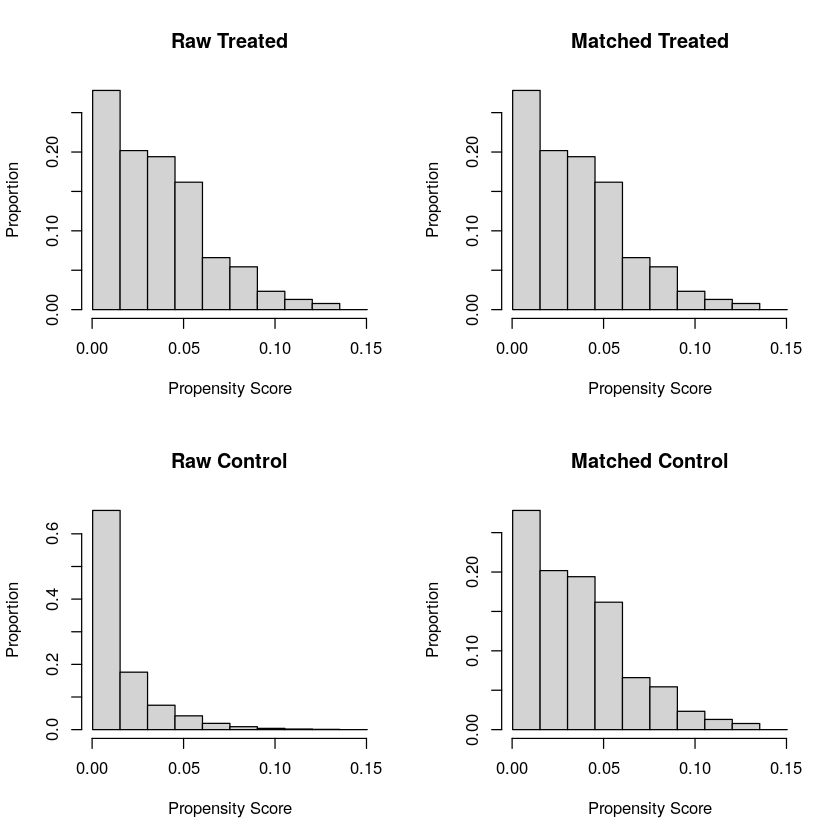

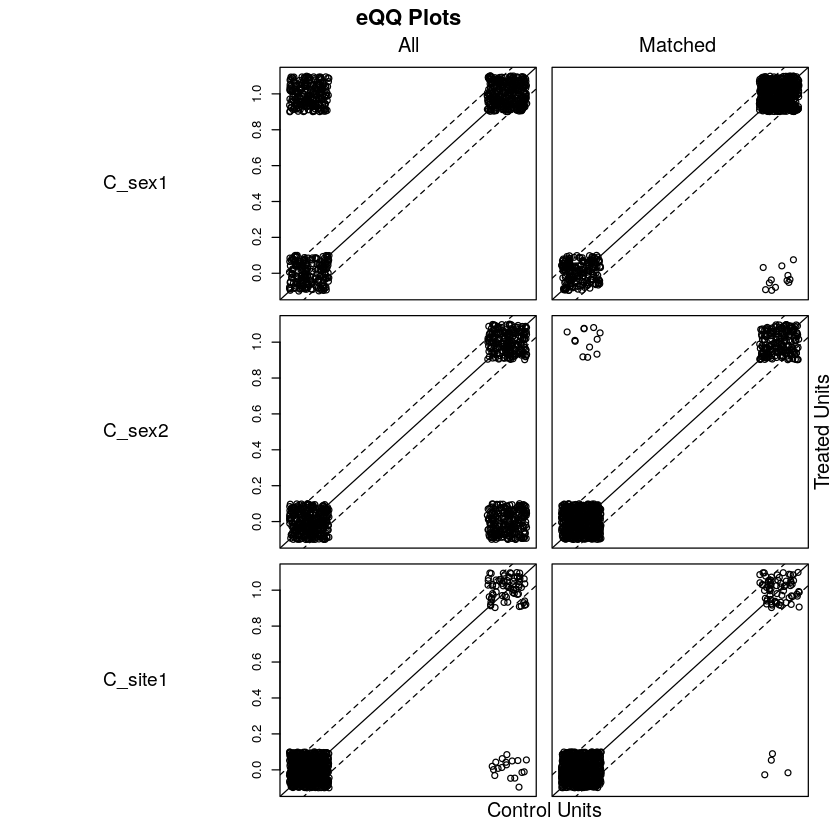

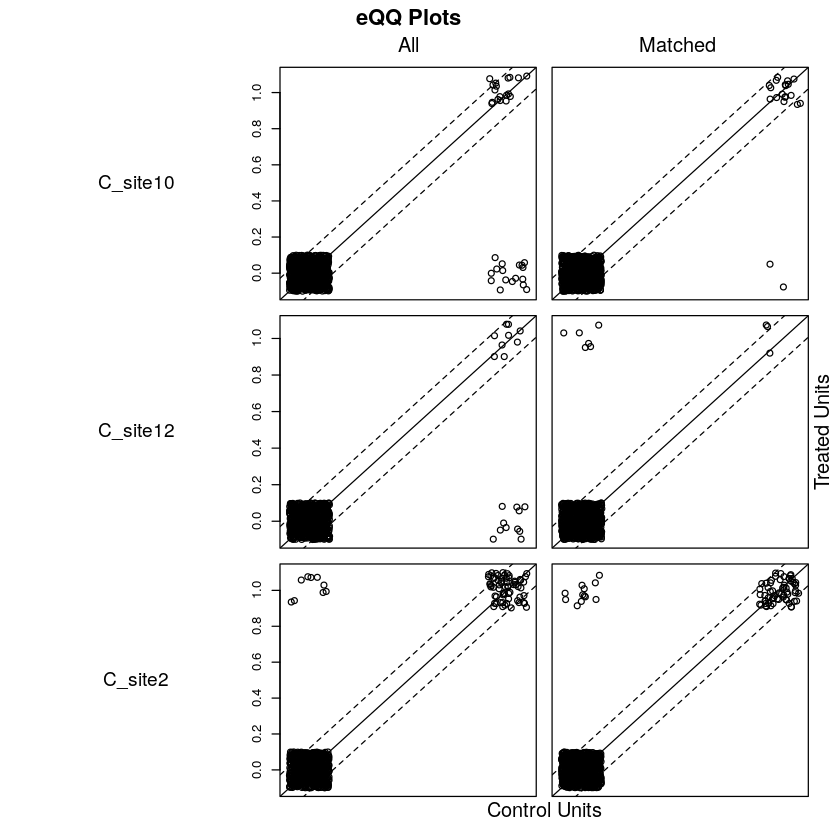

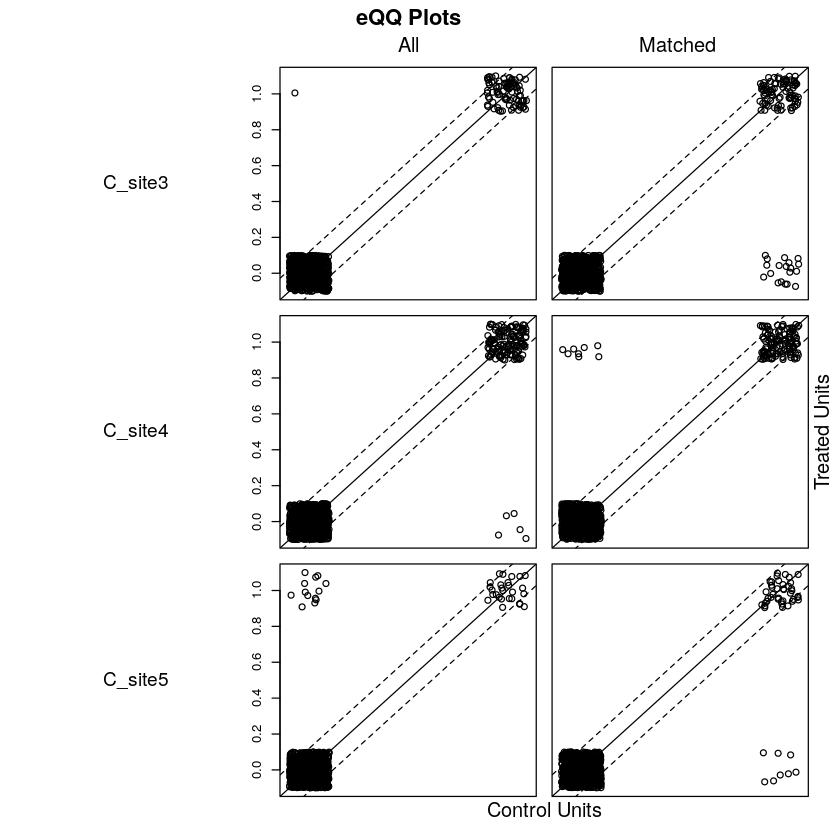

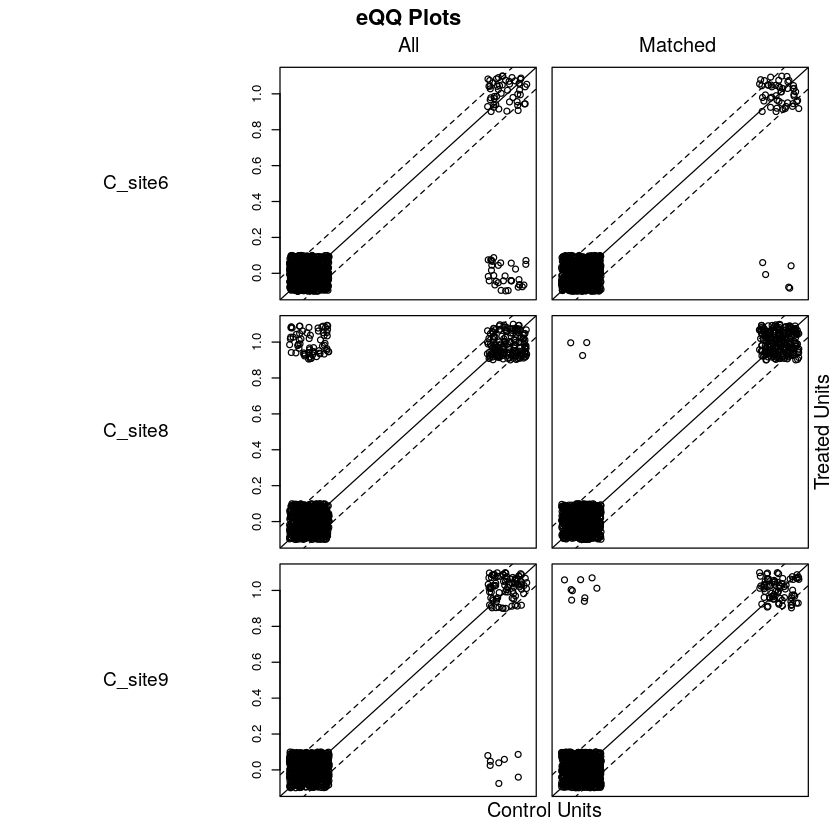

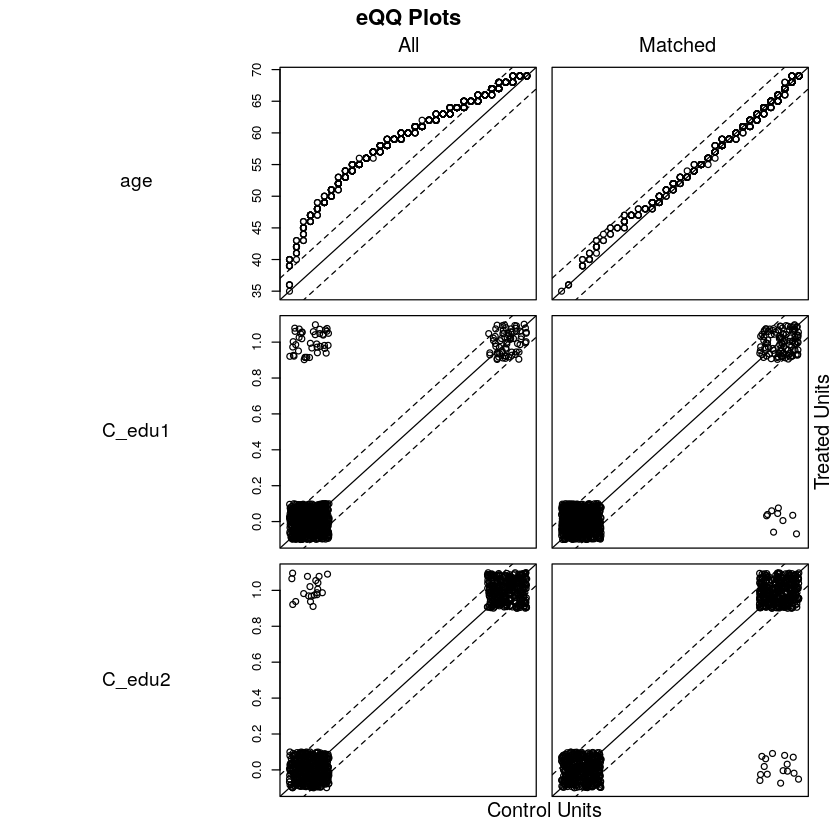

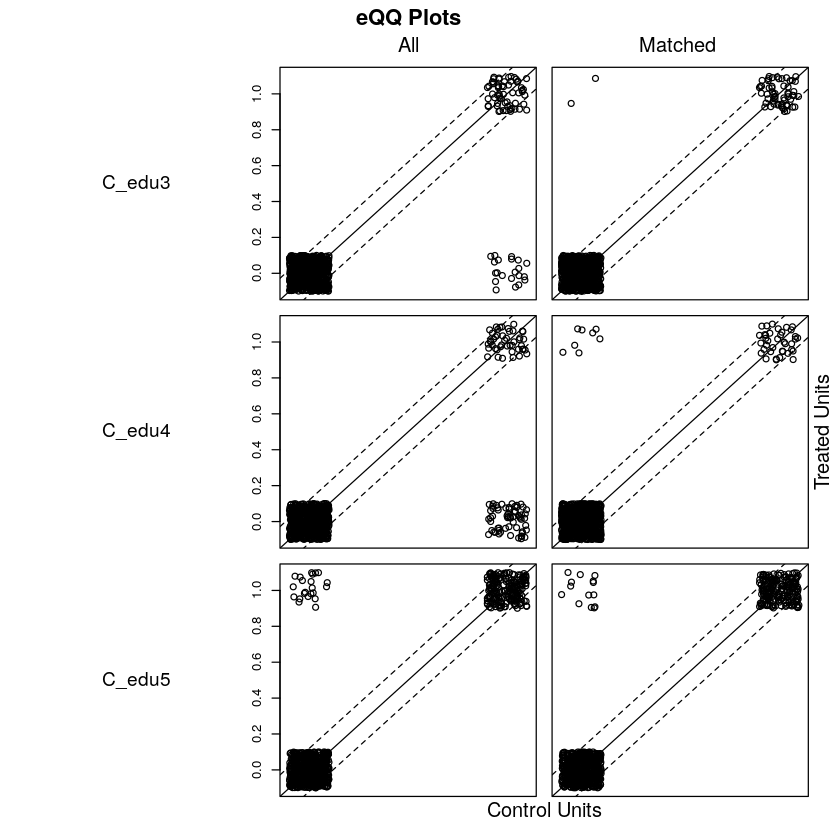

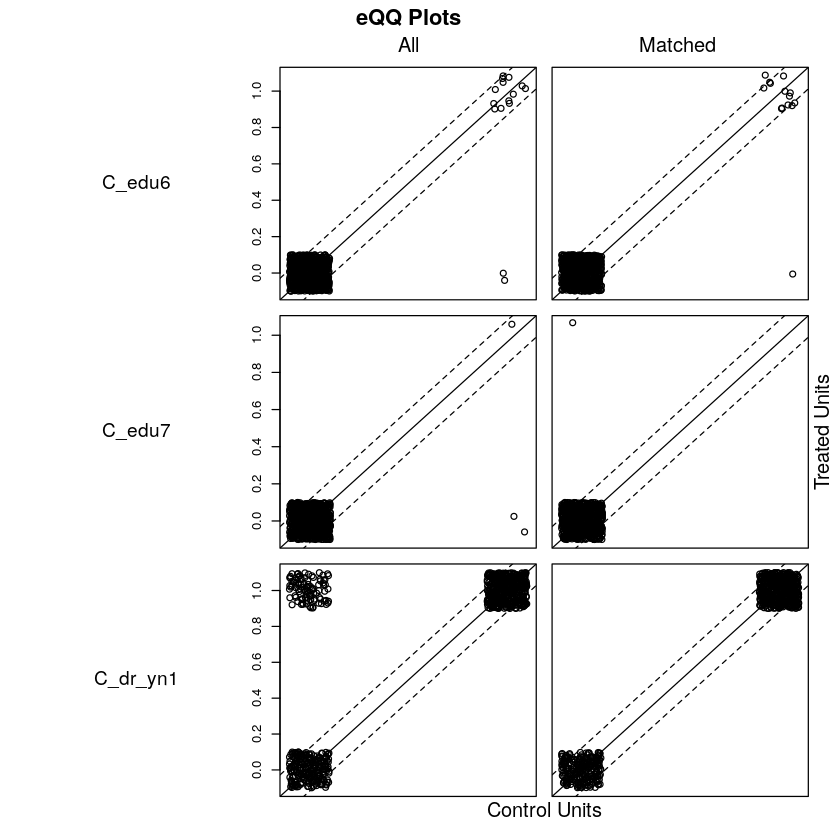

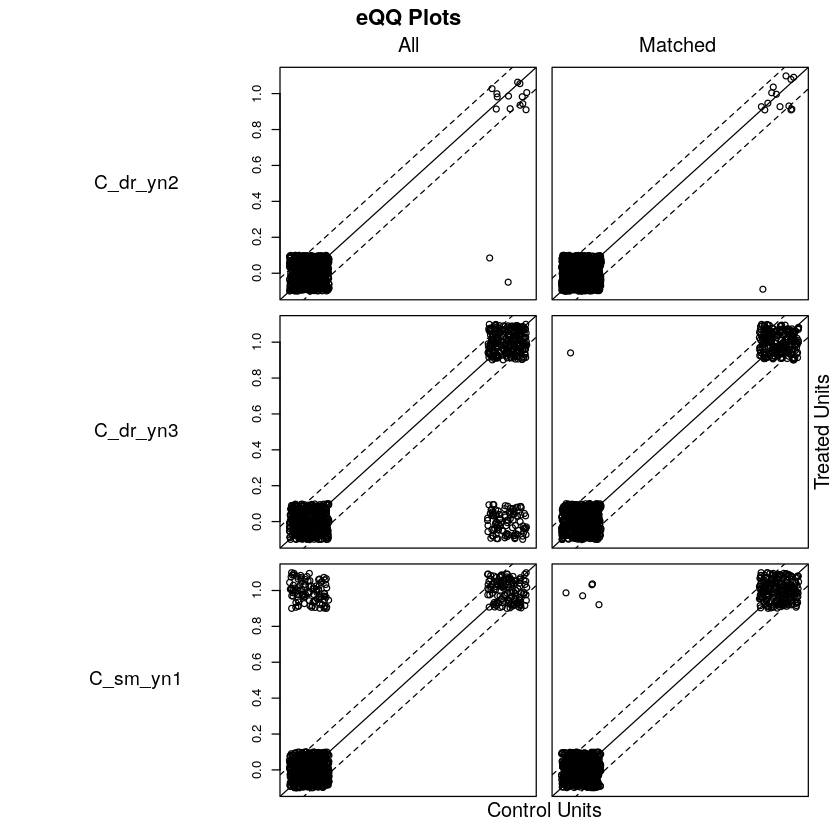

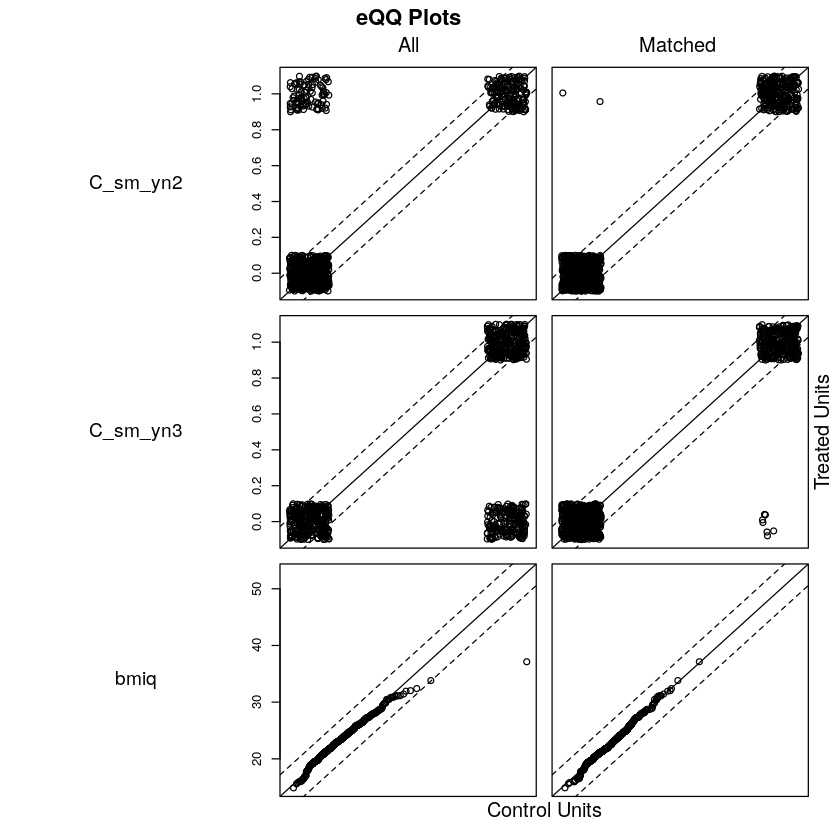

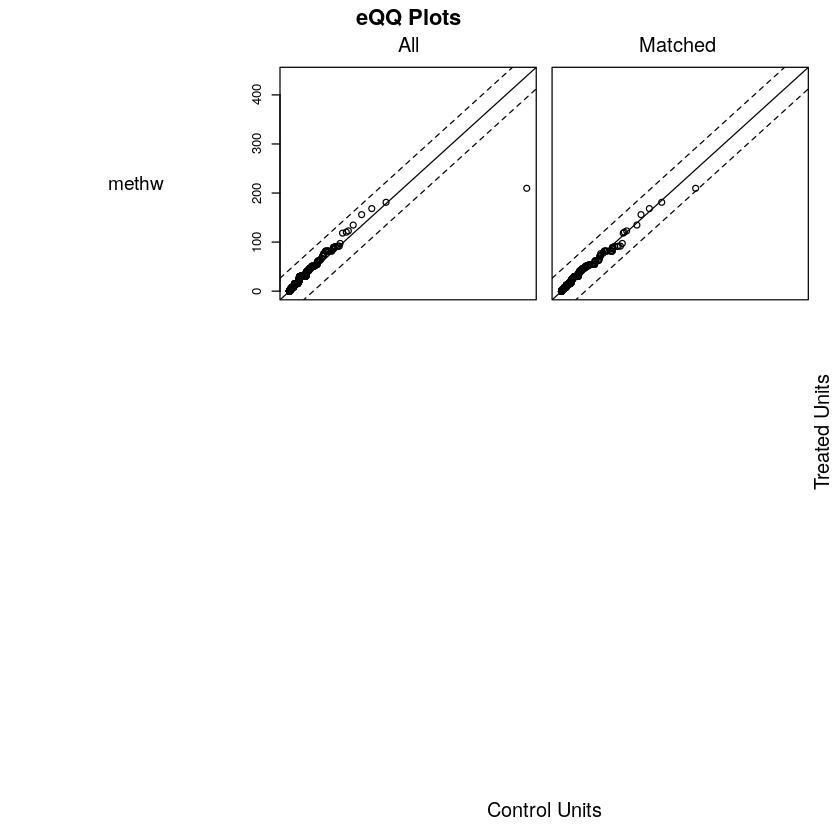

In [220]:
# マッチング前後の傾向スコアの分布図
plot(m.out, type = "hist")
# 共変量のバランスプロット
plot(m.out, type = "qq")

## PSM処理前後の変化図

In [ ]:
# マッチング後のデータフレームを抽出
matched_data <- match.data(m.out)

# 抽出されたデータフレームの確認
head(matched_data)

In [ ]:
# 抽出したい列名 (ベクトルとして定義)
selected_columns <- c("TargetID", "C_sex", "site","C_edu","C_dr_yn","C_sm_yn","age", "bmiq", "methw")

# 元のデータフレームが 'merged_df7' だと仮定します
extracted_df <- merged_df7_cln[ , selected_columns]

# 結果の確認 (最初の数行と列名を表示)
head(extracted_df)
colnames(extracted_df)
# MatchItの結果をデータフレームとして取得 (マッチング前後の重み情報を含む)
m_data <- match.data(m.out, data = extracted_df)

# 欠損値を含む行を落とした元のデータ (比較のため)
# is.na()で重みがNAの行を落とします。
m_data_unmatched <- merged_df7_cln %>% 
  drop_na(
    TargetID, C_sex, site, age, bmiq, methw,  # 数値・二値変数
    C_edu,     # 1. 元のカテゴリ変数名
    C_dr_yn,   # 2. 元のカテゴリ変数名
    C_sm_yn    # 3. 元のカテゴリ変数名
  ) %>%
  mutate(weights = 1, subgroup = "Unmatched")# 全員に重み1を設定

# マッチング後のデータにサブグループラベルを追加
m_data_matched <- m_data %>% 
  mutate(subgroup = "Matched")

# 比較のために2つのデータセットを結合 (rbind)
plot_data <- bind_rows(m_data_unmatched, m_data_matched)

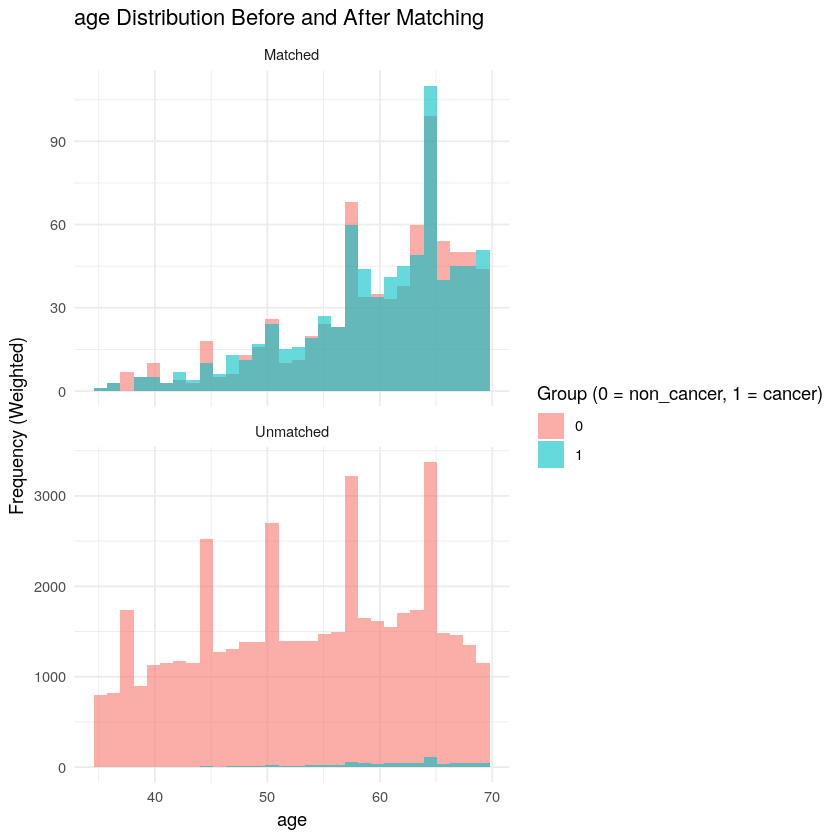

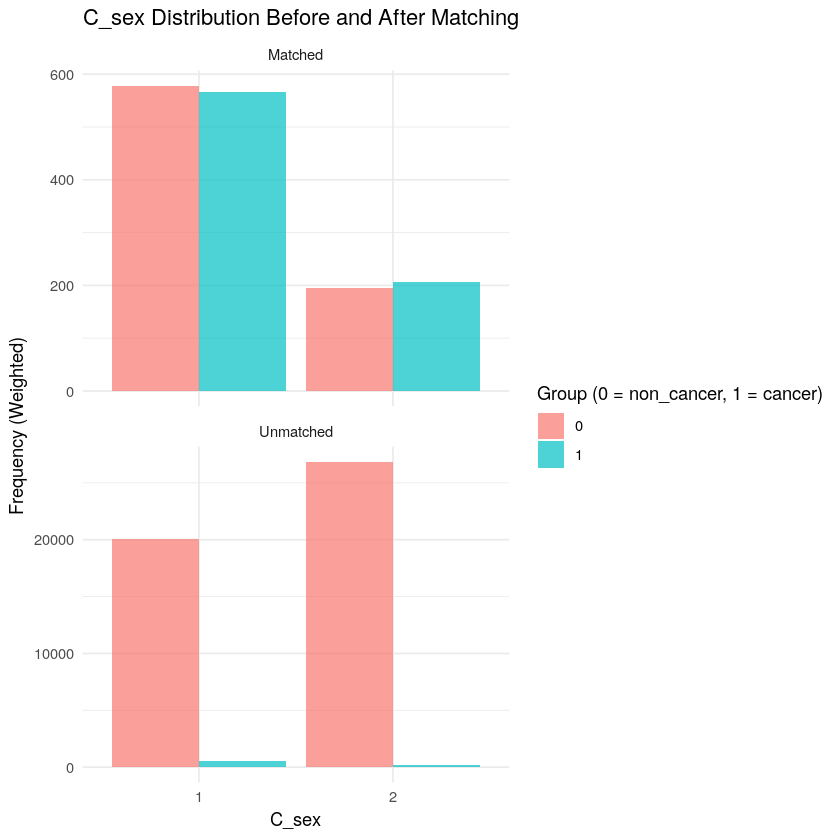

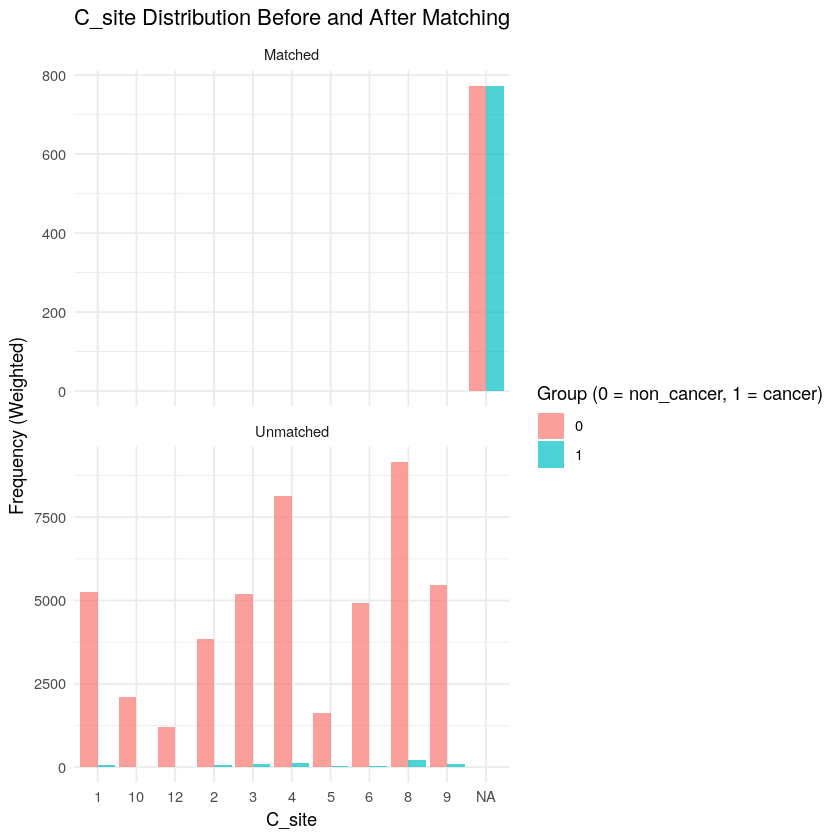

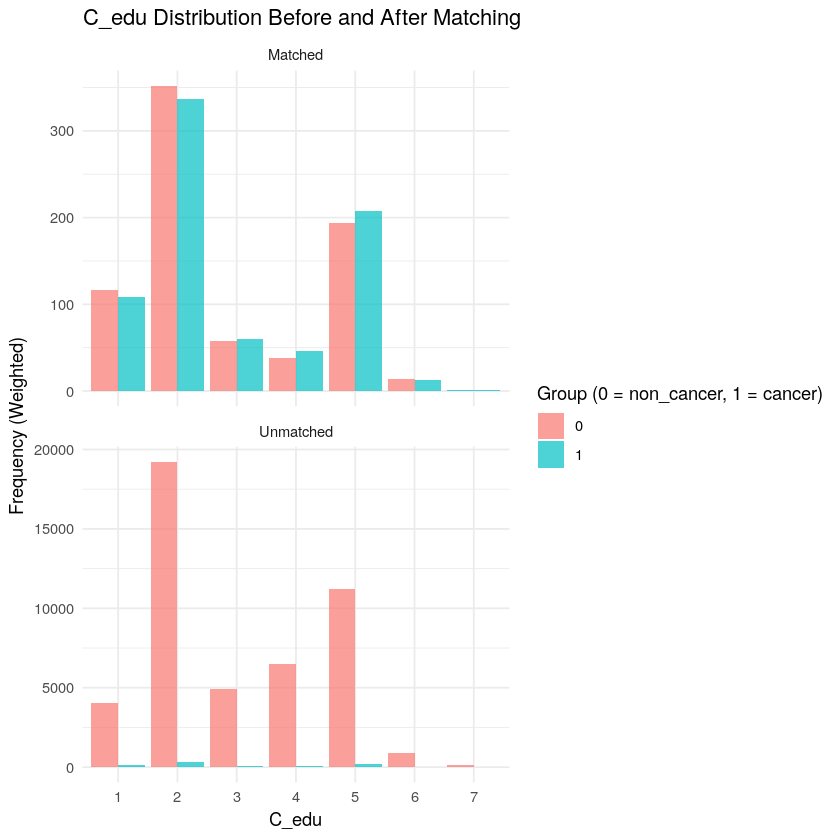

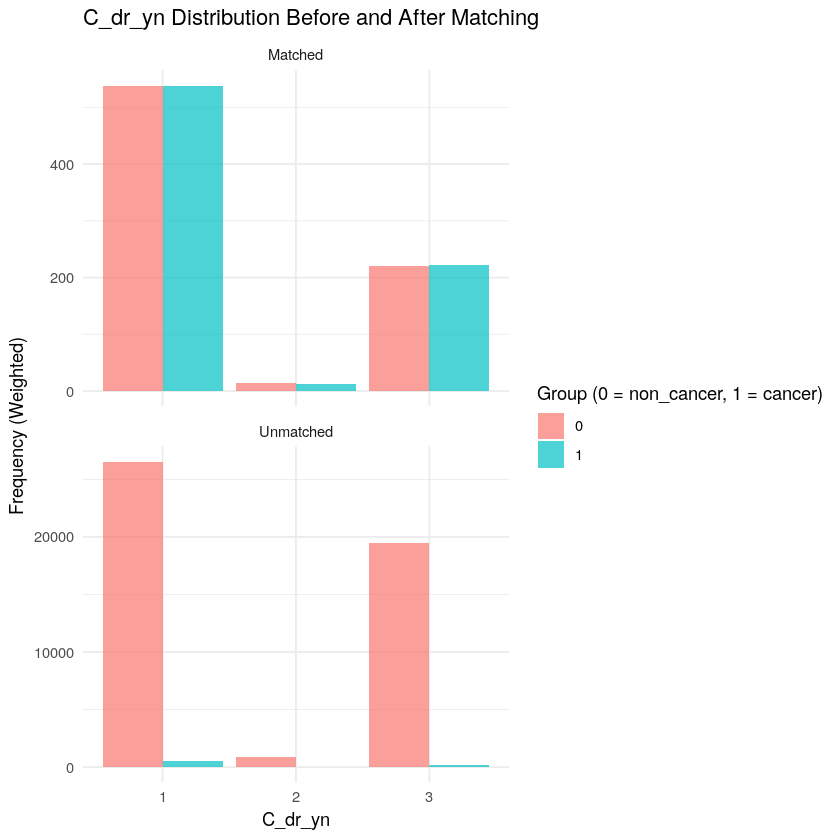

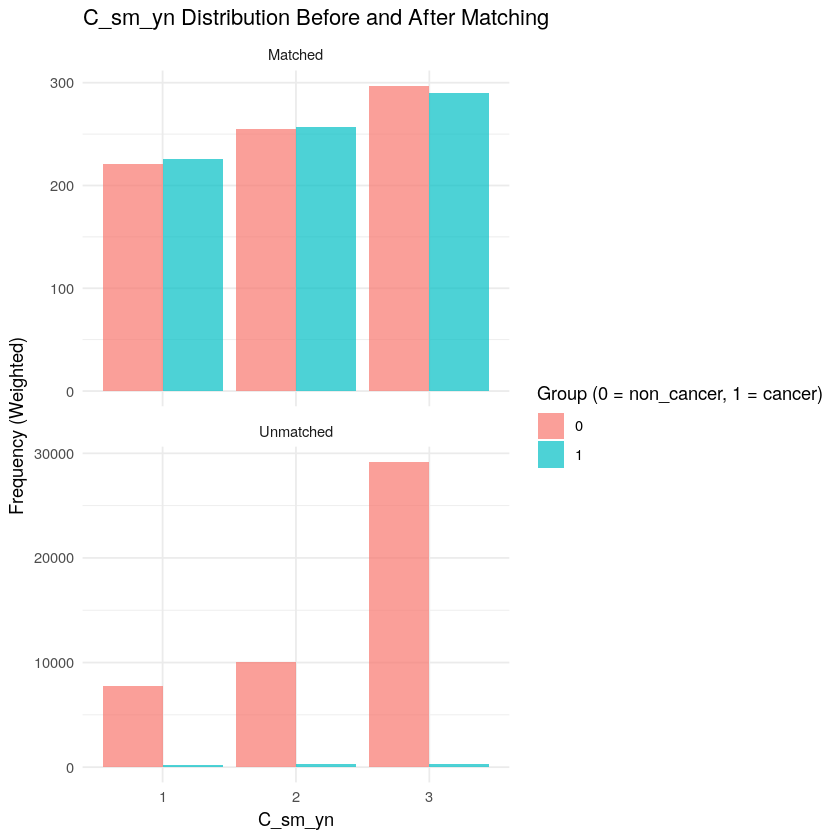

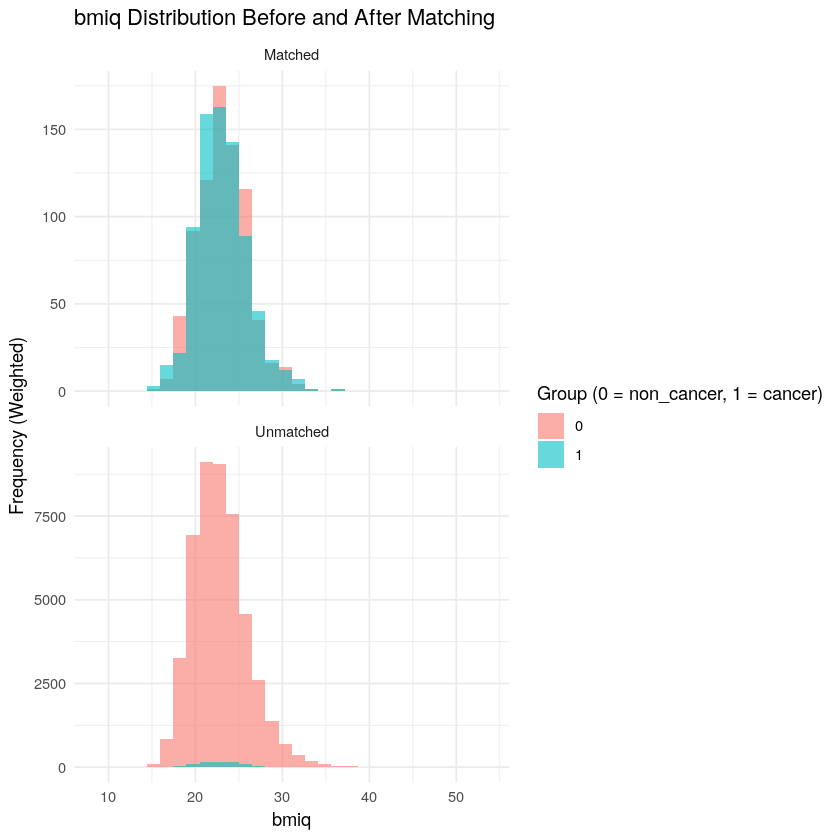

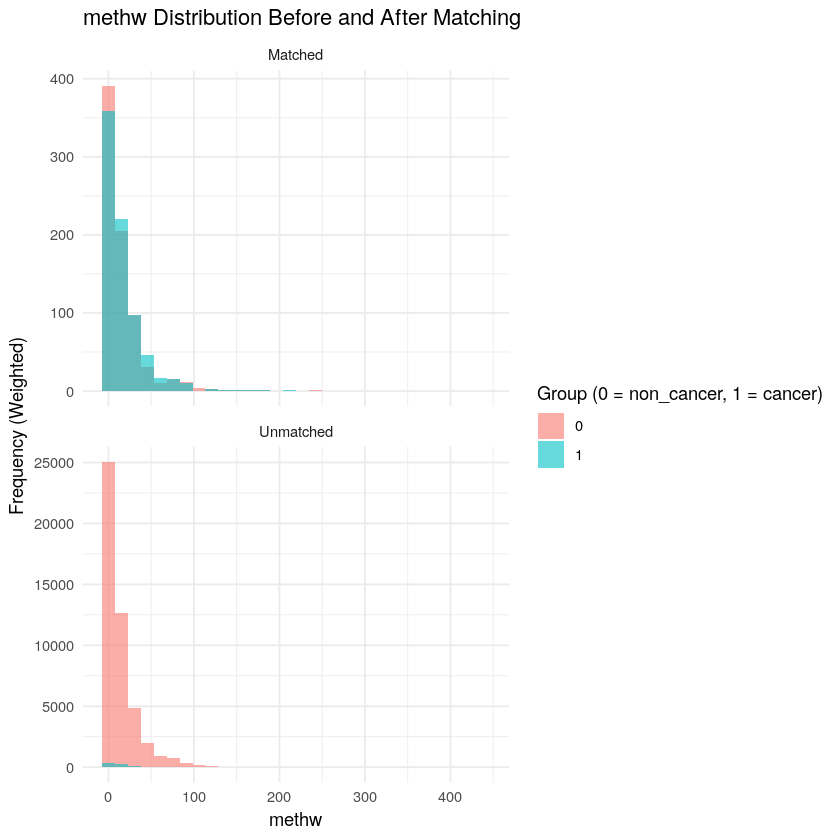

In [223]:
covariates_to_plot <- c("age", "C_sex", "C_site", "C_edu", "C_dr_yn", "C_sm_yn", "bmiq", "methw")

for (var_name in covariates_to_plot) {
  
  # --- 2-1. プロットのベースを作成 ---
  p <- ggplot(plot_data, aes(x = .data[[var_name]], fill = factor(TargetID), weight = weights)) +
    
    # facet_wrapで Before/After を分割
    facet_wrap(~subgroup, scales = "free_y", ncol = 1) + 
    
    # 軸ラベルの設定
    labs(
      title = paste(var_name, "Distribution Before and After Matching"),
      x = var_name,
      y = "Frequency (Weighted)",
      fill = "Group (0 = non_cancer, 1 = cancer)"
    ) +
    theme_minimal()
    
  # 'plot_data'内での変数の型を確認
  var_type <- class(plot_data[[var_name]])
  
  if (var_type %in% c("numeric", "integer", "double")) {
    # age, bmiq, methw のような数値変数: ヒストグラム
    p <- p + geom_histogram(bins = 30, position = "identity", alpha = 0.6)
  } else if (var_type %in% c("factor", "character")) {
    # sex, site, C_edu などのカテゴリ変数: 棒グラフ (count/frequency)
    p <- p + geom_bar(position = "dodge", alpha = 0.7) # position="dodge"で横に並べて比較
  } else {
    # その他の型の変数はスキップまたはエラーメッセージ
    message(paste("Warning: Skipping plot for unknown type of variable:", var_name, "(Type:", var_type, ")"))
    next # 次のループへ
  }
  
  # --- 2-3. プロットを表示/保存 ---
  print(p)
}

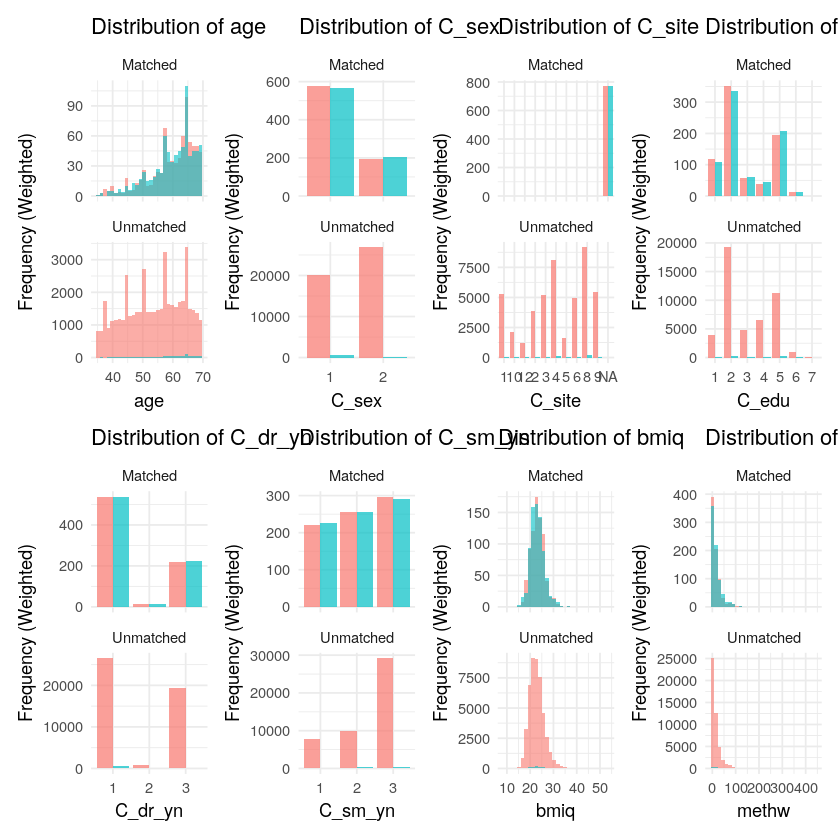

In [230]:
# 結合した図を表示
print(combined_plot)

# ファイルに保存する際に、全体のサイズを調整
ggsave(
  filename = "Combined_Covariate_Balance_Plots.png",
  plot = combined_plot,                               
  width = 24,                                         
  height = 20,                                       
  units = "in"                                        
)

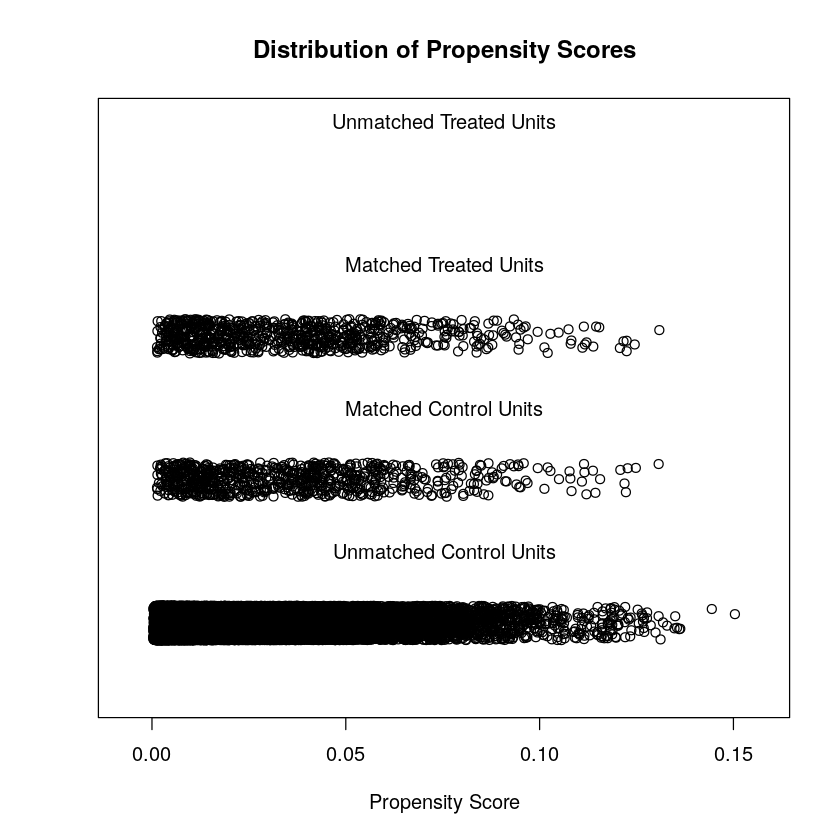

In [231]:
plot(m.out, type = "jitter", interactive = FALSE)

In [232]:
# 1. 保存するファイル名とファイルパスを指定
file_path <- "psm_jitter_plot_balance.png"

# 2. PNGグラフィックデバイスを開始
png(filename = file_path, width = 800, height = 600, units = "px", res = 100)

# 3. プロットコマンドを実行
plot(m.out, type = "jitter", interactive = FALSE)

dev.off()

cat(paste0("Jitterプロットは '", file_path, "' に保存されました。✅\n"))

png 
  2

Jitterプロットは 'psm_jitter_plot_balance.png' に保存されました。✅


## SMD出力

In [233]:
library(cobalt)
bal.tab(m.out, stats = c("m", "v", "ks", "p"), thresholds = c(m = 0.05), un = TRUE)
# PSM実行前のバランス（SMDとP値）を確認
bal.tab(TargetID ~ C_sex + C_site + age + C_edu + C_dr_yn + C_sm_yn + bmiq + methw,
        data = merged_df7_cln,
        stats = c("m", "v", "ks", "p"),
        thresholds = c(m = 0.05),
        un = TRUE) 

Balance Measures
              Type Diff.Un V.Ratio.Un  KS.Un Diff.Adj     M.Threshold
distance  Distance  0.7758     2.2469 0.4029  -0.0000 Balanced, <0.05
C_sex_2     Binary -0.3043          . 0.3043   0.0155 Balanced, <0.05
C_site_1    Binary -0.0229          . 0.0229  -0.0052 Balanced, <0.05
C_site_10   Binary -0.0214          . 0.0214  -0.0026 Balanced, <0.05
C_site_12   Binary -0.0141          . 0.0141   0.0078 Balanced, <0.05
C_site_2    Binary  0.0124          . 0.0124   0.0155 Balanced, <0.05
C_site_3    Binary  0.0019          . 0.0019  -0.0246 Balanced, <0.05
C_site_4    Binary -0.0064          . 0.0064   0.0103 Balanced, <0.05
C_site_5    Binary  0.0172          . 0.0172  -0.0103 Balanced, <0.05
C_site_6    Binary -0.0418          . 0.0418  -0.0065 Balanced, <0.05
C_site_8    Binary  0.0842          . 0.0842   0.0039 Balanced, <0.05
C_site_9    Binary -0.0092          . 0.0092   0.0116 Balanced, <0.05
age        Contin.  0.8691     0.5694 0.2980   0.0196 Balanced, <0.05
C_e

Note: `s.d.denom` not specified; assuming "pooled".


Balance Measures
             Type Diff.Un      M.Threshold.Un V.Ratio.Un  KS.Un
C_sex_2    Binary -0.3043 Not Balanced, >0.05          . 0.3043
C_site_1   Binary -0.0229     Balanced, <0.05          . 0.0229
C_site_10  Binary -0.0214     Balanced, <0.05          . 0.0214
C_site_12  Binary -0.0141     Balanced, <0.05          . 0.0141
C_site_2   Binary  0.0124     Balanced, <0.05          . 0.0124
C_site_3   Binary  0.0019     Balanced, <0.05          . 0.0019
C_site_4   Binary -0.0064     Balanced, <0.05          . 0.0064
C_site_5   Binary  0.0172     Balanced, <0.05          . 0.0172
C_site_6   Binary -0.0418     Balanced, <0.05          . 0.0418
C_site_8   Binary  0.0842 Not Balanced, >0.05          . 0.0842
C_site_9   Binary -0.0092     Balanced, <0.05          . 0.0092
age       Contin.  0.7403 Not Balanced, >0.05     0.5694 0.2980
C_edu_1    Binary  0.0541 Not Balanced, >0.05          . 0.0541
C_edu_2    Binary  0.0263     Balanced, <0.05          . 0.0263
C_edu_3    Binary -0.02

## 平均値　標準偏差　データ数　割合

In [234]:
library(cobalt)

# bal.tabの出力結果
bal.out <- bal.tab(TargetID ~ age + bmiq + methw,
                   data = merged_df7_cln,
                   stats = c("m", "v", "ks", "p"),
                   thresholds = c(m = 0.05),
                   un = TRUE,
                   disp = c("means", "sds")) 
print(bal.out)

Note: `s.d.denom` not specified; assuming "pooled".


Balance Measures
         Type  M.0.Un SD.0.Un  M.1.Un SD.1.Un Diff.Un      M.Threshold.Un
age   Contin. 53.5869  9.5490 59.8486  7.2053  0.7403 Not Balanced, >0.05
bmiq  Contin. 22.8066  3.1867 23.0830  2.9457  0.0901 Not Balanced, >0.05
methw Contin. 13.8333 21.6681 16.6960 24.0319  0.1251 Not Balanced, >0.05
      V.Ratio.Un  KS.Un
age       0.5694 0.2980
bmiq      0.8544 0.0739
methw     1.2301 0.0839

Balance tally for mean differences
                    count
Balanced, <0.05         0
Not Balanced, >0.05     3

Variable with the greatest mean difference
 Variable Diff.Un      M.Threshold.Un
      age  0.7403 Not Balanced, >0.05

Sample sizes
    Control Treated
All   46904     773


In [240]:
library(cobalt)
library(dplyr) 
bal.out <- bal.tab(TargetID ~ age + bmiq + methw,
                   data = merged_df7_cln,
                   stats = c("m", "v", "ks", "p"),
                   thresholds = c(m = 0.05),
                   un = TRUE,
                   disp = c("means", "sds")) 

bal.out <- bal.tab(m.out, 
                   stats = c("m", "v", "ks", "p"),
                   thresholds = c(m = 0.05),
                   un = TRUE,
                   disp = c("means", "sds"),
                   data = merged_df7_cln)

# bal.out$Balance からバランス統計のデータフレームを取得
balance_df <- bal.out$Balance %>%
  # 変数名（行名）を新しい列として保持
  tibble::rownames_to_column("Variable") 

# 保存ファイル名を設定
file_name <- "psm_balance_table.csv"

# write.csvまたはreadr::write_csvで保存
write.csv(balance_df, 
          file = file_name, 
          row.names = FALSE,
          fileEncoding = "UTF-8")

# 保存場所の確認（オプション）
cat("バランス表が現在の作業ディレクトリに保存されました: ", file_name, "\n")
cat("現在の作業ディレクトリ: ", getwd(), "\n")

Note: `s.d.denom` not specified; assuming "pooled".


バランス表が現在の作業ディレクトリに保存されました:  psm_balance_table.csv 
現在の作業ディレクトリ:  /home/jupyter/jmicc/PSM_R 


In [243]:
library(cobalt)
library(dplyr)
library(tibble) 

bal.out <- bal.tab(m.out, 
                   data = merged_df7_cln, 
                   stats = c("m", "v", "ks", "p"),
                   thresholds = c(m = 0.05),
                   un = TRUE,
                   disp = c("means", "sds")) 

print(bal.out)

# bal.out$Balance からバランス統計のデータフレームを取得
balance_df <- bal.out$Balance %>%
  # 変数名（行名）を新しい列として保持
  rownames_to_column("Variable") 

# 保存ファイル名を設定
file_name <- "psm_balance_continuous_table.csv"

# write.csvで保存
write.csv(balance_df, 
          file = file_name, 
          row.names = FALSE, 
          fileEncoding = "UTF-8")

cat("連続変数のPSMバランス表が現在の作業ディレクトリに保存されました: ", file_name, "\n")
cat("現在の作業ディレクトリ: ", getwd(), "\n")

Balance Measures
              Type  M.0.Un SD.0.Un  M.1.Un SD.1.Un Diff.Un V.Ratio.Un  KS.Un
distance  Distance  0.0159  0.0177  0.0365  0.0265  0.7758     2.2469 0.4029
C_sex_2     Binary  0.5721       .  0.2678       . -0.3043          . 0.3043
C_site_1    Binary  0.1122       .  0.0893       . -0.0229          . 0.0229
C_site_10   Binary  0.0447       .  0.0233       . -0.0214          . 0.0214
C_site_12   Binary  0.0257       .  0.0116       . -0.0141          . 0.0141
C_site_2    Binary  0.0820       .  0.0944       .  0.0124          . 0.0124
C_site_3    Binary  0.1107       .  0.1125       .  0.0019          . 0.0019
C_site_4    Binary  0.1732       .  0.1669       . -0.0064          . 0.0064
C_site_5    Binary  0.0345       .  0.0517       .  0.0172          . 0.0172
C_site_6    Binary  0.1052       .  0.0634       . -0.0418          . 0.0418
C_site_8    Binary  0.1952       .  0.2794       .  0.0842          . 0.0842
C_site_9    Binary  0.1166       .  0.1074       . -0.0092 

In [255]:
library(dplyr)
library(tidyr)
library(stringr)

# PSM前後のカウントと割合を計算し整形する関数
calculate_counts <- function(data_df, time_label) {
  
  # 集計対象のカテゴリ変数リスト
  categorical_vars <- c("C_sex", "C_site", "C_edu", "C_dr_yn", "C_sm_yn")
  
  # TargetID, サブクラス, 重み（PSM後のために必要）を選択
  data_df %>%
    select(TargetID, all_of(categorical_vars), any_of(c("weights", "subclass"))) %>%
    
    # Wide形式からLong形式へ変換し、TargetIDとLevelでグループ化
    pivot_longer(cols = all_of(categorical_vars), names_to = "Variable", values_to = "Level") %>%
    group_by(Variable, Level, TargetID) %>%
    summarise(
      Count = n(), # 度数（カウント）
      .groups = 'drop_last'
    ) %>%
    
    # 割合の計算 (TargetIDグループ内の割合)
    mutate(
      Total_N = sum(Count), # TargetIDごとの合計N
      Percentage = round(Count / Total_N * 100, 1), 
      Count_Perc = str_glue("{Count} ({Percentage}%)")
    ) %>%
    ungroup() %>%
    
    # 最終的な表示形式に整形
    select(Variable, Level, TargetID, Count_Perc) %>%
    pivot_wider(names_from = TargetID, values_from = Count_Perc, names_prefix = "TargetID_") %>%
    rename(
      Control = TargetID_0, 
      Case = TargetID_1
    ) %>%
    mutate(Time = time_label)
}
# PSM前 (Unmatched) のカウント
counts_unmatched <- calculate_counts(merged_df7_cln, "PSM前 (Unmatched)")

# PSM後 (Matched) のカウント
counts_matched <- calculate_counts(matched_data, "PSM後 (Matched)")

# 結果を結合し、表示
categorical_vars_table <- bind_rows(counts_unmatched, counts_matched) %>%
  # 変数名、水準、時間を基準に並べ替え
  arrange(Variable, Level, Time)

print(categorical_vars_table)

# A tibble: 50 × 5
   Variable Level Control       Case        Time             
   <chr>    <chr> <glue>        <glue>      <chr>            
 1 C_dr_yn  1     26517 (98%)   538 (2%)    PSM前 (Unmatched)
 2 C_dr_yn  1     538 (50%)     538 (50%)   PSM後 (Matched)  
 3 C_dr_yn  2     903 (98.6%)   13 (1.4%)   PSM前 (Unmatched)
 4 C_dr_yn  2     14 (51.9%)    13 (48.1%)  PSM後 (Matched)  
 5 C_dr_yn  3     19484 (98.9%) 222 (1.1%)  PSM前 (Unmatched)
 6 C_dr_yn  3     221 (49.9%)   222 (50.1%) PSM後 (Matched)  
 7 C_edu    1     4018 (97.4%)  108 (2.6%)  PSM前 (Unmatched)
 8 C_edu    1     117 (52%)     108 (48%)   PSM後 (Matched)  
 9 C_edu    2     19215 (98.3%) 337 (1.7%)  PSM前 (Unmatched)
10 C_edu    2     352 (51.1%)   337 (48.9%) PSM後 (Matched)  
# ℹ 40 more rows


In [256]:
file_name_categorical <- "psm_categorical_table.csv"

# write.csvでデータフレームを保存
write.csv(categorical_vars_table, 
          file = file_name_categorical, 
          row.names = FALSE, 
          fileEncoding = "UTF-8")

cat("カテゴリ変数のバランス表が現在の作業ディレクトリに保存されました: ", file_name_categorical, "\n")
cat("現在の作業ディレクトリ: ", getwd(), "\n")

カテゴリ変数のバランス表が現在の作業ディレクトリに保存されました:  psm_categorical_table.csv 
現在の作業ディレクトリ:  /home/jupyter/jmicc/PSM_R 


In [257]:
library(cobalt)
library(dplyr)

bal_result_matched <- bal.tab(m.out, 
                              stats = c("m", "v", "ks", "p"), 
                              thresholds = c(m = 0.05), 
                              un = TRUE)

bal_result_unmatched <- bal.tab(TargetID ~ C_sex + C_site + age + C_edu + C_dr_yn + C_sm_yn + bmiq + methw,
                                data = merged_df7_cln,
                                stats = c("m", "v", "ks", "p"),
                                thresholds = c(m = 0.05),
                                un = TRUE)

# 例: マッチング後の結果（bal_result_matched）から表を抽出
balance_table_df <- bal_result_matched$Balance

# 抽出したデータフレーム（表）の表示
print("--- Extracted Balance Table (Data Frame) ---")
print(balance_table_df)


if ("Unadj.M.Diff" %in% names(balance_table_df)) {
    clean_table <- balance_table_df %>%
        select(
            Variable, 
            starts_with("Unadj.M"), 
            starts_with("Adj.M"),   
            matches("\\.p\\.")      
        )
    
    print("\n--- Cleaned Balance Table ---")
    print(clean_table)
}

Note: `s.d.denom` not specified; assuming "pooled".


[1] "--- Extracted Balance Table (Data Frame) ---"
              Type      Diff.Un V.Ratio.Un       KS.Un      Diff.Adj
distance  Distance  0.775822940  2.2469382 0.402899490 -1.395047e-05
C_sex_2     Binary -0.304338205         NA 0.304338205  1.552393e-02
C_site_1    Binary -0.022923981         NA 0.022923981 -5.174644e-03
C_site_10   Binary -0.021422441         NA 0.021422441 -2.587322e-03
C_site_12   Binary -0.014069143         NA 0.014069143  7.761966e-03
C_site_2    Binary  0.012418666         NA 0.012418666  1.552393e-02
C_site_3    Binary  0.001896969         NA 0.001896969 -2.457956e-02
C_site_4    Binary -0.006365207         NA 0.006365207  1.034929e-02
C_site_5    Binary  0.017229130         NA 0.017229130 -1.034929e-02
C_site_6    Binary -0.041782875         NA 0.041782875 -6.468305e-03
C_site_8    Binary  0.084223557         NA 0.084223557  3.880983e-03
C_site_9    Binary -0.009204675         NA 0.009204675  1.164295e-02
age        Contin.  0.869053824  0.5693652 0.2980389

In [238]:
file_path <- "balance_statistics_matched.csv" 

write.csv(
    balance_table_df, 
    file = file_path, 
    row.names = FALSE,
    fileEncoding = "UTF-8" # 日本語環境での文字化けを防ぐため
)

print(paste0("バランス統計量の表をディレクトリに保存しました: ", file_path))

[1] "バランス統計量の表をディレクトリに保存しました: balance_statistics_matched.csv"


## T検定

In [191]:
t.test(age ~ TargetID, data = merged_df7_cln)
t.test(bmiq ~ TargetID, data = merged_df7_cln)
t.test(methw ~ TargetID, data = merged_df7_cln)


	Welch Two Sample t-test

data:  age by TargetID
t = -23.82, df = 817.33, p-value < 2.2e-16
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -6.777783 -5.745784
sample estimates:
mean in group 0 mean in group 1 
       53.58686        59.84864 



	Welch Two Sample t-test

data:  bmiq by TargetID
t = -2.584, df = 802.06, p-value = 0.009941
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.48636464 -0.06643572
sample estimates:
mean in group 0 mean in group 1 
       22.80658        23.08298 



	Welch Two Sample t-test

data:  methw by TargetID
t = -3.29, df = 792.82, p-value = 0.001046
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -4.570790 -1.154698
sample estimates:
mean in group 0 mean in group 1 
       13.83328        16.69602 


In [192]:
# 年齢(age)について、TargetID（介入群/非介入群）ごとにt検定を実行
t.test(age ~ TargetID, data = matched_data)
t.test(bmiq ~ TargetID, data = matched_data)
t.test(methw ~ TargetID, data = matched_data)


	Welch Two Sample t-test

data:  age by TargetID
t = -0.37379, df = 1539.1, p-value = 0.7086
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.8809802  0.5989621
sample estimates:
mean in group 0 mean in group 1 
       59.70763        59.84864 



	Welch Two Sample t-test

data:  bmiq by TargetID
t = 0.39813, df = 1543.1, p-value = 0.6906
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.2315238  0.3494428
sample estimates:
mean in group 0 mean in group 1 
       23.14194        23.08298 



	Welch Two Sample t-test

data:  methw by TargetID
t = -0.76595, df = 1543, p-value = 0.4438
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -3.378098  1.480750
sample estimates:
mean in group 0 mean in group 1 
       15.74735        16.69602 


In [193]:
library(dplyr)
library(broom)

matched_data <- match.data(m.out)

# 比較したい連続変数名のリスト
continuous_vars <- c("age", "bmiq", "methw")

# 2. 各変数に対してt検定を実行し、結果を整形 (tidy) して表を作成
t_test_table_matched <- matched_data %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(continuous_vars)) %>%
  
  # データを縦長形式に変換
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でt検定を実行し、broom::tidy()で結果をデータフレームに整形
  do(tidy(t.test(Value ~ TargetID, data = .))) %>%
  
  # 必要な列を選択・整形
  select(Variable, estimate1, estimate2, p.value) %>%
  
  mutate(
    Mean_Case = estimate1, 
    Mean_Control = estimate2,
    P_Value = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  select(Variable, Mean_Case, Mean_Control, P_Value)

# 結果の表を表示
print(t_test_table_matched)
library(dplyr)
library(broom)

# 元のデータセット名 (PSM前のデータ)
data_set <- merged_df7_cln

# 比較したい連続変数名のリスト
continuous_vars <- c("age", "bmiq", "methw")

# 1. 各変数に対してt検定を実行し、結果を整形 (tidy) して結合する
t_test_table <- data_set %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(continuous_vars)) %>%
  
  # データを縦長形式に変換 
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でt検定を実行し、broom::tidy()で結果をデータフレームに整形
  do(tidy(t.test(Value ~ TargetID, data = .))) %>%
  
  # 必要な列を選択 
  select(Variable, estimate1, estimate2, p.value) %>%
  
  # P値を整形
  mutate(
    Mean_TargetID_1 = estimate1, 
    Mean_TargetID_0 = estimate2,
    P_Value = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  select(Variable, Mean_TargetID_1, Mean_TargetID_0, P_Value) # 表示する列を整理

# 結果の表を表示
print(t_test_table)

# A tibble: 3 × 4
# Groups:   Variable [3]
  Variable Mean_Case Mean_Control P_Value
  <chr>        <dbl>        <dbl> <chr>  
1 age           59.7         59.8 0.709  
2 bmiq          23.1         23.1 0.691  
3 methw         15.7         16.7 0.444  
# A tibble: 3 × 4
# Groups:   Variable [3]
  Variable Mean_TargetID_1 Mean_TargetID_0 P_Value
  <chr>              <dbl>           <dbl> <chr>  
1 age                 53.6            59.8 <0.001 
2 bmiq                22.8            23.1 0.00994
3 methw               13.8            16.7 0.00105


In [194]:
# 必要なパッケージをロード
library(dplyr)

# マッチング前の結果テーブルにわかりやすい名前を付けます
t_test_table_original <- t_test_table

merged_t_test_table <- t_test_table_original %>%
  # マッチング前の列名を整理・識別しやすくリネーム
  rename(
    Mean_Case_Original = Mean_TargetID_1,
    Mean_Control_Original = Mean_TargetID_0,
    P_Value_Original = P_Value
  ) %>%
  
  # マッチング後の結果を結合
  left_join(
    t_test_table_matched %>%
      # マッチング後の列名を識別しやすくリネーム
      rename(
        Mean_Case_Matched = Mean_Case,
        Mean_Control_Matched = Mean_Control,
        P_Value_Matched = P_Value
      ),
    by = "Variable" # 'Variable' 列をキーとして結合
  ) %>%
  
  # 結果の列順序を整理 (必要に応じて)
  select(
    Variable,
    Mean_Case_Original, Mean_Control_Original, P_Value_Original,
    Mean_Case_Matched, Mean_Control_Matched, P_Value_Matched
  )

# 統合された結果の表を表示
print(merged_t_test_table)

# A tibble: 3 × 7
# Groups:   Variable [3]
  Variable Mean_Case_Original Mean_Control_Original P_Value_Original
  <chr>                 <dbl>                 <dbl> <chr>           
1 age                    53.6                  59.8 <0.001          
2 bmiq                   22.8                  23.1 0.00994         
3 methw                  13.8                  16.7 0.00105         
# ℹ 3 more variables: Mean_Case_Matched <dbl>, Mean_Control_Matched <dbl>,
#   P_Value_Matched <chr>


In [195]:
library(readr)

file_path <- "t_test_comparison.csv"
write_csv(merged_t_test_table, file_path)
cat(paste0("結果の表は '", file_path, "' に保存されました。\n"))

結果の表は 't_test_comparison.csv' に保存されました。


## カイ2乗検定（エラーによりFisher検定に変更）

In [196]:
#TargetIDごとにカイ二乗検定を実行
chisq.test(table(merged_df7_cln$C_sex, merged_df7_cln$TargetID))
chisq.test(table(merged_df7_cln$C_edu, merged_df7_cln$TargetID))
chisq.test(table(merged_df7_cln$C_dr_yn, merged_df7_cln$TargetID))
chisq.test(table(merged_df7_cln$C_sm_yn, merged_df7_cln$TargetID))
chisq.test(table(merged_df7_cln$C_site, merged_df7_cln$TargetID))


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(merged_df7_cln$C_sex, merged_df7_cln$TargetID)
X-squared = 285.69, df = 1, p-value < 2.2e-16


Warning message in chisq.test(table(merged_df7_cln$C_edu, merged_df7_cln$TargetID)):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  table(merged_df7_cln$C_edu, merged_df7_cln$TargetID)
X-squared = 70.431, df = 6, p-value = 3.336e-13



	Pearson's Chi-squared test

data:  table(merged_df7_cln$C_dr_yn, merged_df7_cln$TargetID)
X-squared = 53.35, df = 2, p-value = 2.601e-12



	Pearson's Chi-squared test

data:  table(merged_df7_cln$C_sm_yn, merged_df7_cln$TargetID)
X-squared = 199.58, df = 2, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  table(merged_df7_cln$C_site, merged_df7_cln$TargetID)
X-squared = 66.166, df = 9, p-value = 8.555e-11


In [197]:
chisq.test(table(matched_data$C_sex, matched_data$TargetID))
chisq.test(table(matched_data$C_edu, matched_data$TargetID))
chisq.test(table(matched_data$C_dr_yn, matched_data$TargetID))
chisq.test(table(matched_data$C_sm_yn, matched_data$TargetID))
chisq.test(table(matched_data$C_site, matched_data$TargetID))


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(matched_data$C_sex, matched_data$TargetID)
X-squared = 0.40676, df = 1, p-value = 0.5236


Warning message in chisq.test(table(matched_data$C_edu, matched_data$TargetID)):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  table(matched_data$C_edu, matched_data$TargetID)
X-squared = 3.007, df = 6, p-value = 0.808



	Pearson's Chi-squared test

data:  table(matched_data$C_dr_yn, matched_data$TargetID)
X-squared = 0.039294, df = 2, p-value = 0.9805



	Pearson's Chi-squared test

data:  table(matched_data$C_sm_yn, matched_data$TargetID)
X-squared = 0.14722, df = 2, p-value = 0.929



	Pearson's Chi-squared test

data:  table(matched_data$C_site, matched_data$TargetID)
X-squared = 7.9259, df = 9, p-value = 0.5416


In [198]:
library(dplyr)
library(broom)

# 元のデータセット名
data_set <- merged_df7_cln

# 比較したいカテゴリ変数名のリスト
categorical_vars <- c("C_sex", "C_edu", "C_dr_yn", "C_sm_yn", "C_site")

# 1. 各カテゴリ変数に対してカイ二乗検定を実行し、結果を整形 (tidy)
chi_sq_test_table <- data_set %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(categorical_vars)) %>%

  # データを縦長形式に変換 (一括で適用するため)
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%

  # 変数ごとにグループ化
  group_by(Variable) %>%

  # グループ内でカイ二乗検定を実行し、broom::tidy()で結果をデータフレームに整形
  do(tidy(chisq.test(.$Value, .$TargetID))) %>%

  # 必要な列を選択・整形
  select(Variable, statistic, parameter, p.value) %>%

  # P値を整形（小数点以下3桁表示、0.001未満は "<0.001"）
  mutate(
    Chi_Square_Stat = round(statistic, 3), # 検定統計量を小数点以下3桁に丸める
    Degrees_of_Freedom = parameter,        # 自由度
    P_Value = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  
  # 表示する列を整理
  select(Variable, Chi_Square_Stat, Degrees_of_Freedom, P_Value)

# 結果の表を表示
print(chi_sq_test_table)

Warning message in chisq.test(.$Value, .$TargetID):
“Chi-squared approximation may be incorrect”


# A tibble: 5 × 4
# Groups:   Variable [5]
  Variable Chi_Square_Stat Degrees_of_Freedom P_Value
  <chr>              <dbl>              <int> <chr>  
1 C_dr_yn             53.4                  2 <0.001 
2 C_edu               70.4                  6 <0.001 
3 C_sex              286.                   1 <0.001 
4 C_site              66.2                  9 <0.001 
5 C_sm_yn            200.                   2 <0.001 


In [199]:
# 必要なパッケージをロード
library(dplyr)
library(broom)

# マッチング後のデータセット名 (m.outの結果、と仮定)
data_set_matched <- matched_data

# 比較したいカテゴリ変数名のリスト
categorical_vars <- c("C_sex", "C_edu", "C_dr_yn", "C_sm_yn", "C_site")

# 1. 各カテゴリ変数に対してFisherの正確確率検定を実行し、結果を整形
chi_sq_test_table_matched <- data_set_matched %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(categorical_vars)) %>%
  
  # データを縦長形式に変換
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でFisherの正確確率検定を実行し、tidy()で結果をデータフレームに整形
  # chisq.test()の期待度数不足の警告を避けるため、fisher.test()を使用
  do(tidy(fisher.test(.$Value, .$TargetID))) %>%
  
  # 必要な列を選択・整形
  select(Variable, p.value) %>%
  
  # P値を整形
  mutate(
    Test_Method_Matched = "Fisher's Exact Test", # 検定方法を明記
    P_Value_Matched = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  
  # 表示する列を整理
  select(Variable, Test_Method_Matched, P_Value_Matched)

# 結果の表を表示
print(chi_sq_test_table_matched)

ERROR: Error in fisher.test(.$Value, .$TargetID): FEXACT error 7(location). LDSTP=18360 is too small for this problem,
  (pastp=245.108, ipn_0:=ipoin[itp=270]=8773, stp[ipn_0]=245.525).
Increase workspace or consider using 'simulate.p.value=TRUE'


## Fisher検定（推定P値の出力）

In [244]:

# 1. C_sex
cat("--- C_sex と TargetID の Fisher の正確確率検定 ---\n")
fisher.test(table(merged_df7_cln$C_sex, merged_df7_cln$TargetID))

# 1. C_edu の Fisher の正確確率検定 (シミュレーションを使用)
cat("--- C_edu と TargetID の Fisher の正確確率検定 (シミュレーション) ---\n")
fisher.test(
    table(merged_df7_cln$C_edu, merged_df7_cln$TargetID), 
    simulate.p.value = TRUE
)

# 2. C_edu の Fisher の正確確率検定 (シミュレーションを使用)
cat("\n--- C_site と TargetID の Fisher の正確確率検定 (シミュレーション) ---\n")
fisher.test(
    table(merged_df7_cln$C_site, merged_df7_cln$TargetID), 
    simulate.p.value = TRUE
)
# 3. C_dr_yn
# --- C_dr_yn の Fisher の正確確率検定 (シミュレーションを使用) ---
cat("--- C_dr_yn と TargetID の Fisher の正確確率検定 (シミュレーション) ---\n")
fisher.test(
    table(merged_df7_cln$C_dr_yn, merged_df7_cln$TargetID), 
    simulate.p.value = TRUE
)

# 4. C_sm_yn
# --- C_dr_yn の Fisher の正確確率検定 (シミュレーションを使用) ---
cat("--- C_sm_yn と TargetID の Fisher の正確確率検定 (シミュレーション) ---\n")
fisher.test(
    table(merged_df7_cln$C_sm_yn, merged_df7_cln$TargetID), 
    simulate.p.value = TRUE
)
# 5. C_site
# --- C_dr_yn の Fisher の正確確率検定 (シミュレーションを使用) ---
cat("--- C_site と TargetID の Fisher の正確確率検定 (シミュレーション) ---\n")
fisher.test(
    table(merged_df7_cln$C_site, merged_df7_cln$TargetID), 
    simulate.p.value = TRUE
)

--- C_sex と TargetID の Fisher の正確確率検定 ---



	Fisher's Exact Test for Count Data

data:  table(merged_df7_cln$C_sex, merged_df7_cln$TargetID)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2318822 0.3216415
sample estimates:
odds ratio 
 0.2735207 


--- C_edu と TargetID の Fisher の正確確率検定 (シミュレーション) ---



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  table(merged_df7_cln$C_edu, merged_df7_cln$TargetID)
p-value = 0.0004998
alternative hypothesis: two.sided



--- C_site と TargetID の Fisher の正確確率検定 (シミュレーション) ---



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  table(merged_df7_cln$C_site, merged_df7_cln$TargetID)
p-value = 0.0004998
alternative hypothesis: two.sided


--- C_dr_yn と TargetID の Fisher の正確確率検定 (シミュレーション) ---



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  table(merged_df7_cln$C_dr_yn, merged_df7_cln$TargetID)
p-value = 0.0004998
alternative hypothesis: two.sided


--- C_sm_yn と TargetID の Fisher の正確確率検定 (シミュレーション) ---



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  table(merged_df7_cln$C_sm_yn, merged_df7_cln$TargetID)
p-value = 0.0004998
alternative hypothesis: two.sided


--- C_site と TargetID の Fisher の正確確率検定 (シミュレーション) ---



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  table(merged_df7_cln$C_site, merged_df7_cln$TargetID)
p-value = 0.0004998
alternative hypothesis: two.sided


In [245]:
# 1. C_sex
cat("--- C_sex (Matched) の Fisher 検定 ---\n")
fisher.test(table(matched_data$C_sex, matched_data$TargetID))

# 2. C_edu
cat("\n--- C_edu (Matched) の Fisher 検定 (シミュレーション) ---\n")
# エラー回避のためシミュレーションを適用
fisher.test(
    table(matched_data$C_edu, matched_data$TargetID), 
    simulate.p.value = TRUE
)

# 3. C_dr_yn
cat("\n--- C_dr_yn (Matched) の Fisher 検定 (シミュレーション) ---\n")
# エラー回避のためシミュレーションを適用
fisher.test(
    table(matched_data$C_dr_yn, matched_data$TargetID), 
    simulate.p.value = TRUE
)

# 4. C_sm_yn
cat("\n--- C_sm_yn (Matched) の Fisher 検定 ---\n")
fisher.test(table(matched_data$C_sm_yn, matched_data$TargetID))

# 5. C_site
cat("\n--- C_site (Matched) の Fisher 検定 (シミュレーション) ---\n")
# エラー回避のためシミュレーションを適用
fisher.test(
    table(matched_data$C_site, matched_data$TargetID), 
    simulate.p.value = TRUE
)

--- C_sex (Matched) の Fisher 検定 ---



	Fisher's Exact Test for Count Data

data:  table(matched_data$C_sex, matched_data$TargetID)
p-value = 0.5236
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8579738 1.3699232
sample estimates:
odds ratio 
  1.083986 



--- C_edu (Matched) の Fisher 検定 (シミュレーション) ---



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  table(matched_data$C_edu, matched_data$TargetID)
p-value = 0.8541
alternative hypothesis: two.sided



--- C_dr_yn (Matched) の Fisher 検定 (シミュレーション) ---



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  table(matched_data$C_dr_yn, matched_data$TargetID)
p-value = 1
alternative hypothesis: two.sided



--- C_sm_yn (Matched) の Fisher 検定 ---



	Fisher's Exact Test for Count Data

data:  table(matched_data$C_sm_yn, matched_data$TargetID)
p-value = 0.9333
alternative hypothesis: two.sided



--- C_site (Matched) の Fisher 検定 (シミュレーション) ---



	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  table(matched_data$C_site, matched_data$TargetID)
p-value = 0.5487
alternative hypothesis: two.sided


In [246]:
# 必要なパッケージをロード
library(dplyr)
library(broom)
library(tidyr) # pivot_longerを使用するため

# 元のデータセット名
data_set <- merged_df7_cln

# 比較したいカテゴリ変数名のリスト
categorical_vars <- c("C_sex", "C_edu", "C_dr_yn", "C_sm_yn", "C_site")

# 1. 各カテゴリ変数に対してFisherの正確確率検定 (シミュレーション) を実行し、結果を整形
chi_sq_test_table_original <- data_set %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(categorical_vars)) %>%
  
  # データを縦長形式に変換
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でFisherの正確確率検定をシミュレーション付きで実行し、tidy()で結果をデータフレームに整形
  # FEXACT error回避のため、simulate.p.value = TRUE を使用
  do(tidy(fisher.test(.$Value, .$TargetID, simulate.p.value = TRUE))) %>%
  
  # 必要な列を選択・整形
  select(Variable, p.value) %>%
  
  # P値を整形（小数点以下3桁表示、0.001未満は "<0.001"）
  mutate(
    Test_Method_Original = "Fisher's Exact (Simulated)", # 検定方法を明記
    P_Value_Original = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  
  # 表示する列を整理
  select(Variable, Test_Method_Original, P_Value_Original)

# 結果の表を表示
print(chi_sq_test_table_original)
library(dplyr)
library(broom)
library(tidyr) # pivot_longerを使用するため

# マッチング後のデータセット
data_set_matched <- matched_data

# 比較したいカテゴリ変数名のリスト
categorical_vars <- c("C_sex", "C_edu", "C_dr_yn", "C_sm_yn", "C_site")

# 1. 各カテゴリ変数に対してFisherの正確確率検定 (シミュレーション) を実行し、結果を整形
chi_sq_test_table_matched <- data_set_matched %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(categorical_vars)) %>%
  
  # データを縦長形式に変換
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でFisherの正確確率検定をシミュレーション付きで実行し、tidy()で結果をデータフレームに整形
  # FEXACT error回避のため、simulate.p.value = TRUE を使用します
  do(tidy(fisher.test(.$Value, .$TargetID, simulate.p.value = TRUE))) %>%
  
  # 必要な列を選択・整形
  select(Variable, p.value) %>%
  
  # P値を整形（小数点以下3桁表示、0.001未満は "<0.001"）
  mutate(
    Test_Method_Matched = "Fisher's Exact (Simulated)", 
    P_Value_Matched = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  
  # 表示する列を整理
  select(Variable, Test_Method_Matched, P_Value_Matched)

# 結果の表を表示
print(chi_sq_test_table_matched)

# A tibble: 5 × 3
# Groups:   Variable [5]
  Variable Test_Method_Original       P_Value_Original
  <chr>    <chr>                      <chr>           
1 C_dr_yn  Fisher's Exact (Simulated) <0.001          
2 C_edu    Fisher's Exact (Simulated) <0.001          
3 C_sex    Fisher's Exact (Simulated) <0.001          
4 C_site   Fisher's Exact (Simulated) <0.001          
5 C_sm_yn  Fisher's Exact (Simulated) <0.001          
# A tibble: 5 × 3
# Groups:   Variable [5]
  Variable Test_Method_Matched        P_Value_Matched
  <chr>    <chr>                      <chr>          
1 C_dr_yn  Fisher's Exact (Simulated) 1              
2 C_edu    Fisher's Exact (Simulated) 0.858          
3 C_sex    Fisher's Exact (Simulated) 0.524          
4 C_site   Fisher's Exact (Simulated) 0.563          
5 C_sm_yn  Fisher's Exact (Simulated) 0.934          


In [247]:
# 必要なパッケージをロード
library(dplyr)

# 統合するためのキーとなる列名 'Variable' を使用して、2つの表を左結合
merged_chi_sq_table <- chi_sq_test_table_original %>%
  
  # マッチング後の結果を結合
  left_join(chi_sq_test_table_matched, by = "Variable") %>%
  
  # 結果の列順序を整理
  select(
    Variable, 
    Test_Method_Original, P_Value_Original, 
    Test_Method_Matched, P_Value_Matched
  )

# 統合された結果の表を表示
print(merged_chi_sq_table)

# A tibble: 5 × 5
# Groups:   Variable [5]
  Variable Test_Method_Original       P_Value_Original Test_Method_Matched      
  <chr>    <chr>                      <chr>            <chr>                    
1 C_dr_yn  Fisher's Exact (Simulated) <0.001           Fisher's Exact (Simulate…
2 C_edu    Fisher's Exact (Simulated) <0.001           Fisher's Exact (Simulate…
3 C_sex    Fisher's Exact (Simulated) <0.001           Fisher's Exact (Simulate…
4 C_site   Fisher's Exact (Simulated) <0.001           Fisher's Exact (Simulate…
5 C_sm_yn  Fisher's Exact (Simulated) <0.001           Fisher's Exact (Simulate…
# ℹ 1 more variable: P_Value_Matched <chr>


In [248]:
library(readr) 
file_path <- "chi_sq_fisher_comparison.csv"
write_csv(merged_chi_sq_table, file_path)
cat(paste0("カテゴリ変数の統合結果は '", file_path, "' に保存されました。\n"))

カテゴリ変数の統合結果は 'chi_sq_fisher_comparison.csv' に保存されました。


## K-S検定

In [249]:
#分布がTargetID（介入群/非介入群）で等しいかをKS検定で確認
ks.test(merged_df7_cln$age[merged_df7_cln$TargetID == 1], 
        merged_df7_cln$age[merged_df7_cln$TargetID == 0])   
ks.test(merged_df7_cln$bmiq[merged_df7_cln$TargetID == 1],  
        merged_df7_cln$bmiq[merged_df7_cln$TargetID == 0])   
ks.test(merged_df7_cln$methw[merged_df7_cln$TargetID == 1],  
        merged_df7_cln$methw[merged_df7_cln$TargetID == 0])  
ks.test(matched_data$age[matched_data$TargetID == 1],  
        matched_data$age[matched_data$TargetID == 0])   
ks.test(matched_data$bmiq[matched_data$TargetID == 1],  
        matched_data$bmiq[matched_data$TargetID == 0])   
ks.test(matched_data$methw[matched_data$TargetID == 1],  
        matched_data$methw[matched_data$TargetID == 0])   

Warning message in ks.test.default(merged_df7_cln$age[merged_df7_cln$TargetID == :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  merged_df7_cln$age[merged_df7_cln$TargetID == 1] and merged_df7_cln$age[merged_df7_cln$TargetID == 0]
D = 0.29804, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test.default(merged_df7_cln$bmiq[merged_df7_cln$TargetID == :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  merged_df7_cln$bmiq[merged_df7_cln$TargetID == 1] and merged_df7_cln$bmiq[merged_df7_cln$TargetID == 0]
D = 0.073865, p-value = 0.0004979
alternative hypothesis: two-sided


Warning message in ks.test.default(merged_df7_cln$methw[merged_df7_cln$TargetID == :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  merged_df7_cln$methw[merged_df7_cln$TargetID == 1] and merged_df7_cln$methw[merged_df7_cln$TargetID == 0]
D = 0.083871, p-value = 4.515e-05
alternative hypothesis: two-sided


Warning message in ks.test.default(matched_data$age[matched_data$TargetID == 1], :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  matched_data$age[matched_data$TargetID == 1] and matched_data$age[matched_data$TargetID == 0]
D = 0.021992, p-value = 0.9921
alternative hypothesis: two-sided


Warning message in ks.test.default(matched_data$bmiq[matched_data$TargetID == 1], :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  matched_data$bmiq[matched_data$TargetID == 1] and matched_data$bmiq[matched_data$TargetID == 0]
D = 0.040103, p-value = 0.5631
alternative hypothesis: two-sided


Warning message in ks.test.default(matched_data$methw[matched_data$TargetID == 1], :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  matched_data$methw[matched_data$TargetID == 1] and matched_data$methw[matched_data$TargetID == 0]
D = 0.049159, p-value = 0.3077
alternative hypothesis: two-sided


In [250]:
library(dplyr)
library(broom)
library(tidyr)

# 比較したい連続変数名のリスト (T検定と同じ)
continuous_vars <- c("age", "bmiq", "methw")
ks_test_table_original <- merged_df7_cln %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(continuous_vars)) %>%
  
  # データを縦長形式に変換
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でKS検定を実行し、broom::tidy()で結果をデータフレームに整形
  do(tidy(ks.test(.$Value[.$TargetID == 1], 
                  .$Value[.$TargetID == 0]))) %>%
  
  # 必要な列を選択・整形
  select(Variable, statistic, p.value) %>%
  
  mutate(
    KS_Stat_Original = round(statistic, 4), # KS統計量 (D値) を小数点以下4桁に丸める
    P_Value_Original = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  
  select(Variable, KS_Stat_Original, P_Value_Original)
ks_test_table_matched <- matched_data %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(continuous_vars)) %>%
  
  # データを縦長形式に変換
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でKS検定を実行し、tidy()で結果をデータフレームに整形
  do(tidy(ks.test(.$Value[.$TargetID == 1], 
                  .$Value[.$TargetID == 0]))) %>%
  
  # 必要な列を選択・整形
  select(Variable, statistic, p.value) %>%
  
  mutate(
    KS_Stat_Matched = round(statistic, 4), 
    P_Value_Matched = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  
  select(Variable, KS_Stat_Matched, P_Value_Matched)
merged_ks_test_table <- ks_test_table_original %>%
  # Variableをキーとしてマッチング後の結果を結合
  left_join(ks_test_table_matched, by = "Variable") %>%
  
  # 結果の列順序を整理
  select(
    Variable, 
    KS_Stat_Original, P_Value_Original, 
    KS_Stat_Matched, P_Value_Matched
  )

# 統合された結果の表を表示
print(merged_ks_test_table)

Warning message in ks.test.default(.$Value[.$TargetID == 1], .$Value[.$TargetID == :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(.$Value[.$TargetID == 1], .$Value[.$TargetID == :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(.$Value[.$TargetID == 1], .$Value[.$TargetID == :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(.$Value[.$TargetID == 1], .$Value[.$TargetID == :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(.$Value[.$TargetID == 1], .$Value[.$TargetID == :
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(.$Value[.$TargetID == 1], .$Value[.$TargetID == :
“p-value will be approximate in the presence of ties”


# A tibble: 3 × 5
# Groups:   Variable [3]
  Variable KS_Stat_Original P_Value_Original KS_Stat_Matched P_Value_Matched
  <chr>               <dbl> <chr>                      <dbl> <chr>          
1 age                0.298  <0.001                    0.022  0.992          
2 bmiq               0.0739 <0.001                    0.0401 0.563          
3 methw              0.0839 <0.001                    0.0492 0.308          


In [251]:
library(readr) 
file_path <- "ks_test_distribution_comparison.csv"
write_csv(merged_ks_test_table, file_path)
cat(paste0("KS検定の統合結果は '", file_path, "' に保存されました。✅\n"))

KS検定の統合結果は 'ks_test_distribution_comparison.csv' に保存されました。✅


## Wilcoxon検定

In [252]:
# 加工前のデータ（merged_df7_cln）を使用し、ageの中央値をTargetIDで比較
wilcox.test(age ~ TargetID, data = merged_df7_cln)
wilcox.test(bmiq ~ TargetID, data = merged_df7_cln)
wilcox.test(methw ~ TargetID, data = merged_df7_cln)
# TargetIDごとにWilcoxon順位和検定を実行
# (データが正規分布しない場合のバランス評価やアウトカム比較に使用)
wilcox.test(age ~ TargetID, data = matched_data)
wilcox.test(bmiq ~ TargetID, data = matched_data)
wilcox.test(methw ~ TargetID, data = matched_data)


	Wilcoxon rank sum test with continuity correction

data:  age by TargetID
W = 11181824, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  bmiq by TargetID
W = 16802889, p-value = 0.0004788
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  methw by TargetID
W = 16722620, p-value = 0.0001942
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  age by TargetID
W = 299761, p-value = 0.9095
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  bmiq by TargetID
W = 303967, p-value = 0.5534
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  methw by TargetID
W = 286136, p-value = 0.1479
alternative hypothesis: true location shift is not equal to 0


In [253]:
# 必要なパッケージをロード
library(dplyr)
library(broom)
library(tidyr) # pivot_longerを使用

# 比較したい連続変数名のリスト
continuous_vars <- c("age", "bmiq", "methw")
wilcox_test_table_original <- merged_df7_cln %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(continuous_vars)) %>%
  
  # データを縦長形式に変換
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でWilcoxon順位和検定を実行し、tidy()で結果をデータフレームに整形
  do(tidy(wilcox.test(Value ~ TargetID, data = .))) %>%
  
  # 必要な列を選択・整形
  select(Variable, statistic, p.value) %>%
  
  mutate(
    # WilcoxonのW統計量をそのまま格納
    W_Stat_Original = statistic, 
    P_Value_Original = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  
  select(Variable, W_Stat_Original, P_Value_Original)

wilcox_test_table_matched <- matched_data %>%
  # TargetIDと対象変数のみを選択
  select(TargetID, all_of(continuous_vars)) %>%
  
  # データを縦長形式に変換
  tidyr::pivot_longer(cols = -TargetID, names_to = "Variable", values_to = "Value") %>%
  
  # 変数ごとにグループ化
  group_by(Variable) %>%
  
  # グループ内でWilcoxon順位和検定を実行し、tidy()で結果をデータフレームに整形
  do(tidy(wilcox.test(Value ~ TargetID, data = .))) %>%
  
  # 必要な列を選択・整形
  select(Variable, statistic, p.value) %>%
  
  mutate(
    W_Stat_Matched = statistic, 
    P_Value_Matched = format.pval(p.value, digits = 3, eps = 0.001, scientific = FALSE)
  ) %>%
  
  select(Variable, W_Stat_Matched, P_Value_Matched)

merged_wilcox_test_table <- wilcox_test_table_original %>%
  # Variableをキーとしてマッチング後の結果を結合
  left_join(wilcox_test_table_matched, by = "Variable") %>%
  
  # 結果の列順序を整理
  select(
    Variable, 
    W_Stat_Original, P_Value_Original, 
    W_Stat_Matched, P_Value_Matched
  )

# 統合された結果の表を表示
print(merged_wilcox_test_table)

# A tibble: 3 × 5
# Groups:   Variable [3]
  Variable W_Stat_Original P_Value_Original W_Stat_Matched P_Value_Matched
  <chr>              <dbl> <chr>                     <dbl> <chr>          
1 age            11181824. <0.001                  299761  0.91           
2 bmiq           16802889  <0.001                  303967  0.553          
3 methw          16722620  <0.001                  286136. 0.148          


In [254]:
library(readr) 
file_path <- "wilcoxon_test_comparison.csv"
write_csv(merged_wilcox_test_table, file_path)
cat(paste0("Wilcoxon検定の統合結果は '", file_path, "' に保存されました。✅\n"))

Wilcoxon検定の統合結果は 'wilcoxon_test_comparison.csv' に保存されました。✅
